In [28]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg
import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

### Загрузка данных

In [29]:
# загрузка pезультатов A/B теста

public_key = 'https://disk.yandex.ru/d/FPMcY4_9kTUpNg' # Сюда вписываете вашу ссылку
#df_names = ['assessment',  'courses', 'studentAssessment','studentRegistration']

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key = public_key))
response = requests.get(final_url)
df = response.json()['href']
# Загружаем файл и сохраняем его
download_response = requests.get(final_url)

df_AB = pd.read_csv(df, sep = ';', index_col=0)

### Исследование данных

In [30]:
df_AB.info()
# исследуемый признак имеет не численный тип данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   value              1000 non-null   object
 1   experimentVariant  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [31]:
#  замена десятичного разделителя на точку
df_AB['value'] = df_AB.value.str.replace(pat = ',', repl='.')

In [32]:
# перевод типа объект в тип число
df_AB['value'] = pd.to_numeric(df_AB.value)

In [33]:
df_AB.info()
# тип данных поменялся

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


In [34]:
#проверим объем наблюдений в группах
df_AB.groupby('experimentVariant').size()
#кол-во наблюдений в группах равное

experimentVariant
Control      500
Treatment    500
dtype: int64

In [35]:
df_AB.describe()
#по описательной статистике явно есть выбросы.
#медиана и средняя имеют одну разрядность, а вот стандартная ошибка очень большая

,value
count,1000.000000
mean,18.674183
std,132.135045
min,6.436541
25%,9.414051
50%,10.020862
75%,10.669292
max,3000.000000


<AxesSubplot:>

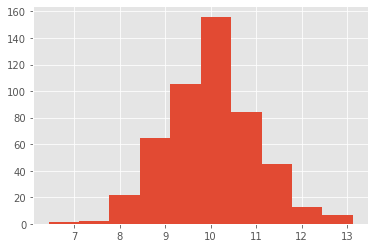

In [36]:
# данные в контрольной группе визуально имееют нормальное распределение
df_AB.query('experimentVariant == "Control"').value.hist()

<AxesSubplot:>

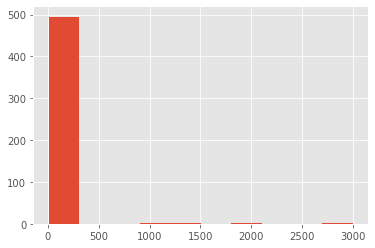

In [37]:
# данные в тестовой группе имеют явно скошенное распределение.
# есть несколько выбрасов
# по графику, можно попробовать избавиться от выбросов больше 500, потом посчитаю их количество. может стоит дальше работать без них и это позволит нормаировать распределение
df_AB.query('experimentVariant == "Treatment"').value.hist()

In [38]:
df_AB = df_AB.query('value < 500')

<AxesSubplot:>

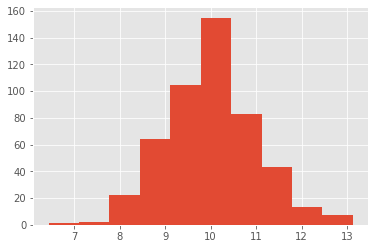

In [39]:
# распределение в тестовой группе приняло нормальный - колокообразный вид после исключения выбрасов
df_AB.query('experimentVariant == "Treatment"').value.hist()

In [40]:
# изменение в объеме выборки теста, по сравнению с котрольной группой, после удаления выбрасов
df_AB.groupby('experimentVariant')['value'].count().pct_change().mul(100)
# наблюдений в тестовой группе стало на 1% меньше, чем в контрольной было 500, стало 495
# выборку считаем репрезентативной, кол-во наблюдений > 30

experimentVariant
Control      NaN
Treatment   -1.0
Name: value, dtype: float64

In [41]:
df_AB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 1 to 995
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              995 non-null    float64
 1   experimentVariant  995 non-null    object 
dtypes: float64(1), object(1)
memory usage: 23.3+ KB


### Проверка на соответствие для проведения тестов

**чтобы провести t-test нужно соблюсти условия:**
1. репрезентативная выборка, наблюдений больше 30 *(проверено на шаге по исследованию описательных статистик)*
2. распределение признака стремиться к нормальному
3. дисперсия внутри контрольной и тестовой групп должна быть примерно одинаковой

#### 2. распределение признака стремиться к нормальному

***Гипотеза:*** Н0 - распределения в группах соответствуют нормальному

***ВЫВОД:*** При визуальном анализе и проверки распределения на нормальность мы **не получили статистически значимых отклонений**, чтобы отвергнуть H0.

Text(0.5, 1.0, 'Control')

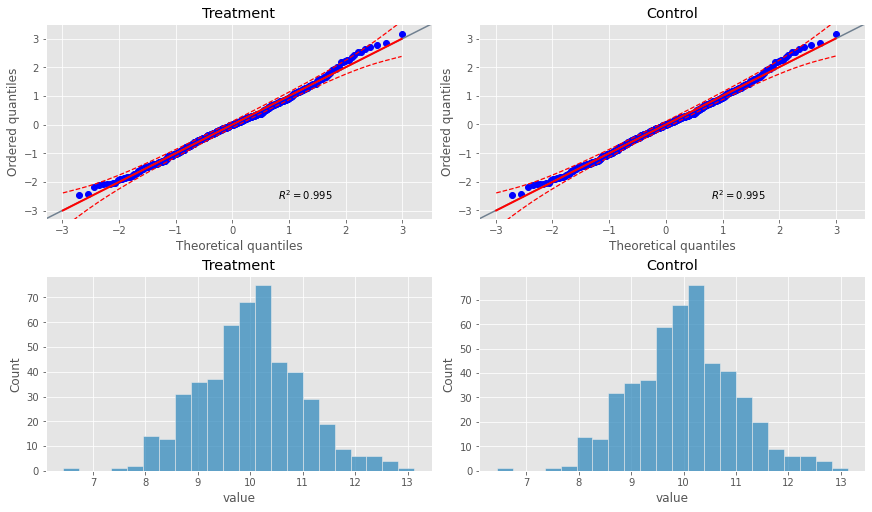

In [42]:
# проверка распределения на соотвествие "нормальному"
# строим гистограммы и QQplot

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,7), constrained_layout = True)

pg.qqplot(x = df_AB.query('experimentVariant == "Treatment"').value, ax = axes[0,0])
pg.qqplot(x = df_AB.query('experimentVariant == "Control"').value,  ax = axes[0,1])

sns.histplot(x = df_AB.query('experimentVariant == "Treatment"').value, ax = axes[1,0])
sns.histplot(x = df_AB.query('experimentVariant == "Control"').value, ax = axes[1,1])



axes[0,0].set_title('Treatment')
axes[0,1].set_title('Control')
axes[1,0].set_title('Treatment')
axes[1,1].set_title('Control')



# после удаления выбросов, сделанных на этапе проверки описательных статистик, данные в обоих группах стремяться к нормальному распределению

In [43]:
# у нас выборка очень большая, поэтому тест Шопиро будет очень чувствителен к выбросам и будет велика ошибка I рода
print(f'''TEST GROUP : {stats.shapiro(df_AB.query('experimentVariant == "Treatment"').value)}''')
print(f'''CONTROL GROUP : {stats.shapiro(df_AB.query('experimentVariant == "Control"').value)}''')

TEST GROUP : ShapiroResult(statistic=0.9955515265464783, pvalue=0.17188233137130737)
CONTROL GROUP : ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)


In [17]:
# тест на нормальность, менее чувствительный к большим выборкам
print(f'''TEST GROUP : {stats.normaltest(df_AB.query('experimentVariant == "Treatment"').value)}''')
print(f'''CONTROL GROUP : {stats.normaltest(df_AB.query('experimentVariant == "Control"').value)}''')

TEST GROUP : NormaltestResult(statistic=3.4264513588191425, pvalue=0.18028331749803517)
CONTROL GROUP : NormaltestResult(statistic=2.943458720256407, pvalue=0.2295282048395919)


In [18]:
# тест на нормальность, менее чувствительный к большим выборкам, реализованный в библиотеке пингвин
pg.normality(df_AB, dv = 'value', group = 'experimentVariant' , method = 'normaltest')

,W,pval,normal
Control,2.943459,0.229528,True
Treatment,3.426451,0.180283,True


#### 3. проверка дисперсий на равенство

***Гипотеза:*** Н0 - дисперсия в контрольной группе равна дисперсии в тестовой

***ВЫВОД:*** мы **не получили** статистически значимое различие p - value > 0.05, Н0 не отклоняем

In [44]:
# тест на равность дисперсий показал, что оснований отклонить H0 нет
pg.homoscedasticity(df_AB, dv = 'value', group = 'experimentVariant')

,W,pval,equal_var
levene,0.004298,0.947742,True


###  Проведение тестов

***Гипотеза:*** H0 - в тестовой и контрольной группе нет значимых различий
1. t-test
2. u - test
3. bootstrap

### 1. t-test
в целом, благодаря преобразованиям - исключению из выборки выбросов, условия для качественного теста соблюдены. Есть только небольшое различие в размере выборки


***ВЫВОД:*** в результате t-test мы не можем отклонить H0 

In [48]:
%%time
# ttest
pg.ttest(df_AB.query('experimentVariant == "Treatment"').value, stats.normaltest(df_AB.query('experimentVariant == "Control"').value))

CPU times: total: 15.6 ms
Wall time: 11 ms


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.212981,1.0021,two-sided,0.101243,"[-8.73, 25.6]",8.599029,2.672e+06,1.0


### 2. u-test
Был бы полезен для проверки равенства распределений и показал , возможно, адекватный результат, если бы не избавилась от выбросов. 

***ВЫВОД:*** в результате u-test мы должны отклонить H0. <br>
    В случае когда все уловия для проведения параметрического теста соблюдены, непараметрический тест проводить не зачем.<br> 
    Поэтому результат этого теста, в данном A/B тесте не следует рассматривать.

In [49]:
%%time
#mwu

pg.mwu(df_AB.query('experimentVariant == "Treatment"').value, stats.normaltest(df_AB.query('experimentVariant == "Control"').value))

CPU times: total: 0 ns
Wall time: 5.98 ms


,U-val,alternative,p-val,RBC,CLES
MWU,990.0,two-sided,0.000016,-1.0,1.0


### 3. bootstrap
Не важно условие на равенство наблюдений в выборках и не сильно чувствителен к выбросам. В качестве метрики используется среднее арифметическое значение.

***ВЫВОД:*** в результате bootstrap мы не можем отклонить H0 

In [22]:
#bootstrap

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [23]:
x = df_AB.query('experimentVariant == "Treatment"').value
y = df_AB.query('experimentVariant == "Control"').value

  0%|          | 0/2000 [00:00<?, ?it/s]

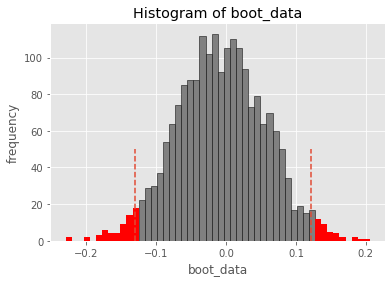

CPU times: total: 547 ms
Wall time: 547 ms


In [50]:
%%time
booted_data = get_bootstrap(x, y, boot_it = 2000)

In [25]:
booted_data["p_value"]

0.9603579824867163

In [26]:
booted_data["quants"]

,0
0.025,-0.124781
0.975,0.122332


### Заключение:

1. На первом этапе EDA обнаружили небольшие выбросы, которые исключены, так как их количество очень мало, а сами выбросы являются аномальными.
2. Условия для проведения t-testa были соблюдены, кроме того в bootstrap мы получили аналогичный результат об отсутствии изменений в средних значениях в тестовой и контрольной группах. Но так как bootstrap использует больше мощности, и соответственно времени, то в нашем случае стоит использовать t-test.
3. по результатам уровень заработка не изменился.


# Ответ преподавателя


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

Хорошего дня!